## Comparação Modelos

In [1]:
!pip uninstall -y segment-anything
!pip uninstall -y sam-2 sam2
!pip uninstall -y numpy


!pip install opencv-python matplotlib
!pip install git+https://github.com/facebookresearch/segment-anything.git

Found existing installation: segment_anything 1.0
Uninstalling segment_anything-1.0:
  Successfully uninstalled segment_anything-1.0
Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
numba 

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from PIL import Image
import cv2
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", device)

DEVICE: cuda


In [3]:
class CellDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.imgs = sorted([f for f in os.listdir(img_dir) if f.endswith(".tif")])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith(".tif")])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = np.array(Image.open(os.path.join(self.img_dir, self.imgs[idx])).convert("RGB"))
        mask = np.array(Image.open(os.path.join(self.mask_dir, self.masks[idx])))

        return {
            "img": img,
            "mask": mask
        }


In [4]:
def prompt_point(mask):
    ys, xs = np.where(mask > 0)
    if len(xs) == 0:
        return None
    cx = xs.mean()
    cy = ys.mean()
    coords = torch.tensor([[cx, cy]], device=device)
    labels = torch.tensor([1], device=device)
    return coords, labels

def prompt_box(mask):
    ys, xs = np.where(mask > 0)
    if len(xs) == 0:
        return None
    x1, y1 = xs.min(), ys.min()
    x2, y2 = xs.max(), ys.max()
    box = torch.tensor([[x1, y1, x2, y2]], device=device)
    return box

def prompt_dense(mask):
    m = torch.tensor(mask[None, None].astype(float), device=device)
    return m



In [5]:
from segment_anything import SamPredictor

sam = sam_model_registry["vit_b"](checkpoint="/kaggle/input/sam-vit-b/pytorch/default/1/sam_vit_b_01ec64.pth").to(device)
print(sam.prompt_encoder)
# Freeze image & prompt encoders
for p in sam.image_encoder.parameters():
    p.requires_grad = False
for p in sam.prompt_encoder.parameters():
    p.requires_grad = False

# Only mask decoder will train
for p in sam.mask_decoder.parameters():
    p.requires_grad = True

sam_transform = ResizeLongestSide(sam.image_encoder.img_size)

predictor = SamPredictor(sam)

PromptEncoder(
  (pe_layer): PositionEmbeddingRandom()
  (point_embeddings): ModuleList(
    (0-3): 4 x Embedding(1, 256)
  )
  (not_a_point_embed): Embedding(1, 256)
  (mask_downscaling): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm2d()
    (2): GELU(approximate='none')
    (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LayerNorm2d()
    (5): GELU(approximate='none')
    (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (no_mask_embed): Embedding(1, 256)
)


In [6]:
def dice_loss(pred, gt):
    pred = torch.sigmoid(pred)
    inter = (pred * gt).sum()
    union = pred.sum() + gt.sum()
    return 1 - (2*inter + 1e-7)/(union + 1e-7)

def total_loss(logits, gt_small):
    bce = F.binary_cross_entropy_with_logits(logits, gt_small)
    dsc = dice_loss(logits, gt_small)
    return bce + dsc


In [7]:
def sam_forward(img_np, mask_np, mode):
    # 1. Preprocessamento da Imagem
    original_size = img_np.shape[:2]
    input_image_np = sam_transform.apply_image(img_np)
    input_image_torch = torch.as_tensor(input_image_np, device=device)
    input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
    input_image = sam.preprocess(input_image_torch)
    
    # 2. Codificação da Imagem (Image Encoder)
    with torch.no_grad():
        image_embedding = sam.image_encoder(input_image)

    # 3. Preparação dos Prompts (Prompt Encoder)
    sparse_embeddings, dense_embeddings = None, None
    ys, xs = np.where(mask_np > 0)
    if len(xs) == 0:
        return torch.zeros((1, 1, 256, 256), device=device, requires_grad=True)

    if mode == "point":
        cy, cx = int(ys.mean()), int(xs.mean())
        coords_np = np.array([[cx, cy]])
        coords_trans = sam_transform.apply_coords(coords_np, original_size)
        
        coords_torch = torch.as_tensor(coords_trans, dtype=torch.float, device=device)[None, :, :]
        labels_torch = torch.tensor([1], device=device)[None, :]
        
        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
            points=(coords_torch, labels_torch),
            boxes=None,
            masks=None,
        )

    elif mode == "box":
        x1, y1 = xs.min(), ys.min()
        x2, y2 = xs.max(), ys.max()
        
        box_np = np.array([[x1, y1, x2, y2]])
        box_trans = sam_transform.apply_boxes(box_np, original_size)
        
        box_torch = torch.as_tensor(box_trans, dtype=torch.float, device=device)[None, :]
        
        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )

    elif mode == "mask":
        mask_small = cv2.resize(mask_np.astype(float), (256, 256))
        mask_torch = torch.as_tensor(mask_small, device=device).float()
        mask_torch = mask_torch[None, None, :, :] # (B, C, H, W)
        
        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
            points=None,
            boxes=None,
            masks=mask_torch,
        )

    # 4. Decodificação da Máscara (Mask Decoder)
    low_res_masks, iou_predictions = sam.mask_decoder(
        image_embeddings=image_embedding,
        image_pe=sam.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    
    return low_res_masks

In [8]:
def train_sam(mode, train_loader, epochs=4):
    optimizer = torch.optim.AdamW(
        [p for p in sam.mask_decoder.parameters()], # Treinando apenas o decoder
        lr=1e-5, weight_decay=1e-4
    )

    sam.train()

    for epoch in range(epochs):
        loop = tqdm(train_loader, desc=f"Training [{mode}] Epoch {epoch+1}/{epochs}")
        epoch_losses = []
        
        for sample in loop:
            img_np = sample["img"][0].numpy()
            mask_full = sample["mask"][0].numpy() # Máscara original com IDs (0, 1, 2...)

            obj_ids = np.unique(mask_full)
            obj_ids = obj_ids[obj_ids > 0]

            if len(obj_ids) == 0:
                continue

            target_id = np.random.choice(obj_ids)
            binary_mask = (mask_full == target_id).astype(np.uint8)

            # Passamos a máscara binária da ÚNICA célula para gerar o prompt e treinar
            logits = sam_forward(img_np, binary_mask, mode)

            # Preparar o Ground Truth (GT) para cálculo da Loss
            gt_small = torch.tensor(binary_mask[None, None], device=device).float()
            gt_small = F.interpolate(gt_small, size=logits.shape[-2:], mode="nearest")

            loss = total_loss(logits, gt_small)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            loop.set_postfix({"loss": np.mean(epoch_losses)})

    torch.save(sam.state_dict(), f"sam_finetuned_{mode}.pth")
    print(f"Modelo salvo: sam_finetuned_{mode}.pth")

In [9]:
images_dir = "/kaggle/input/cellseg/DIC-C2DH-HeLa/01"
masks_dir  = "/kaggle/input/cellseg/DIC-C2DH-HeLa/01_ST/SEG"

train_dataset = CellDataset(images_dir, masks_dir)
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=True)

modes = ["point", "box", "mask"]

for m in modes:
    train_sam(m, train_loader)

Training [point] Epoch 4/4: 100%|██████████| 84/84 [00:41<00:00,  2.03it/s, loss=0.176]


Modelo salvo: sam_finetuned_point.pth


Training [box] Epoch 4/4: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s, loss=0.0971]


Modelo salvo: sam_finetuned_box.pth


Training [mask] Epoch 4/4: 100%|██████████| 84/84 [00:40<00:00,  2.07it/s, loss=0.153]


Modelo salvo: sam_finetuned_mask.pth


In [10]:
def evaluate(mode, test_loader):
    # Carrega os pesos treinados
    checkpoint_path = f"sam_finetuned_{mode}.pth"
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint {checkpoint_path} não encontrado!")
        return

    sam.load_state_dict(torch.load(checkpoint_path))
    sam.eval()

    all_ious = []
    all_dices = []

    with torch.no_grad():
        for sample in tqdm(test_loader, desc=f"Evaluating {mode}"):
            img_np = sample["img"][0].numpy()
            mask_full = sample["mask"][0].numpy() # Máscara com IDs
            
            # Pega todos os IDs de células nesta imagem
            obj_ids = np.unique(mask_full)
            obj_ids = obj_ids[obj_ids > 0] # Remove o fundo

            # Se não tem célula, pula
            if len(obj_ids) == 0:
                continue

            # Loop por CADA CÉLULA da imagem (Avaliação Instância por Instância)
            for target_id in obj_ids:
                binary_mask = (mask_full == target_id).astype(np.uint8)
                
                # Roda o SAM para esta célula específica
                logits = sam_forward(img_np, binary_mask, mode)
                
                mask_pred_prob = torch.sigmoid(logits)
                mask_pred_prob = mask_pred_prob.detach().cpu().numpy().squeeze()
                
                # Resize da predição de volta para o tamanho original da imagem para comparar
                mask_pred_up = cv2.resize(mask_pred_prob, (mask_full.shape[1], mask_full.shape[0]), interpolation=cv2.INTER_LINEAR)
                mask_pred_bin = mask_pred_up > 0.5
                
                # Calcula métricas comparando a predição com a máscara binária ORIGINAL (full resolution)
                gt_binary_original = (binary_mask > 0)
                
                iou_score = iou(mask_pred_bin, gt_binary_original)
                dice_score = dice(mask_pred_bin, gt_binary_original)
                
                all_ious.append(iou_score)
                all_dices.append(dice_score)

    print(f"\nResultados para Modo = {mode}")
    print(f"Total de Células Avaliadas: {len(all_ious)}")
    print(f"Mean IoU:  {np.mean(all_ious):.4f}")
    print(f"Mean Dice: {np.mean(all_dices):.4f}")
    print("-" * 30)

def iou(pred, gt):
    intersection = (pred & gt).sum()
    union = (pred | gt).sum()
    return intersection / union if union > 0 else 0.0

def dice(pred, gt):
    intersection = (pred & gt).sum()
    return (2. * intersection) / (pred.sum() + gt.sum() + 1e-7)

In [11]:
test_dataset = CellDataset("/kaggle/input/cellseg/DIC-C2DH-HeLa/02",
                           "/kaggle/input/cellseg/DIC-C2DH-HeLa/02_ST/SEG")

test_loader = DataLoader(test_dataset, batch_size=1)

for m in ["point", "box", "mask"]:
    evaluate(m, test_loader)


Evaluating point: 100%|██████████| 84/84 [07:37<00:00,  5.45s/it]



Resultados para Modo = point
Total de Células Avaliadas: 988
Mean IoU:  0.7298
Mean Dice: 0.8356
------------------------------


Evaluating box: 100%|██████████| 84/84 [07:36<00:00,  5.44s/it]



Resultados para Modo = box
Total de Células Avaliadas: 988
Mean IoU:  0.8366
Mean Dice: 0.9081
------------------------------


Evaluating mask: 100%|██████████| 84/84 [07:36<00:00,  5.44s/it]


Resultados para Modo = mask
Total de Células Avaliadas: 988
Mean IoU:  0.7209
Mean Dice: 0.7852
------------------------------


--- Visualizando Mode: POINT ---
Encontradas 10 células na imagem. Processando point...


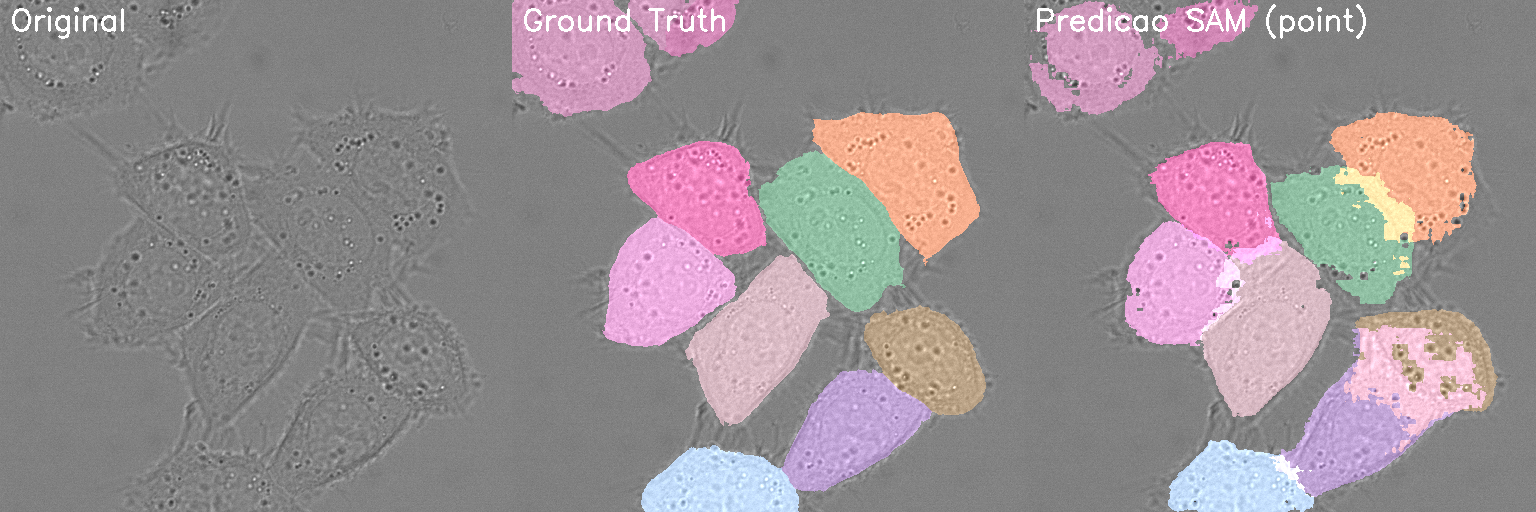

Imagem salva com sucesso: resultado_segmentacao_point.png

--- Visualizando Mode: BOX ---
Encontradas 10 células na imagem. Processando box...


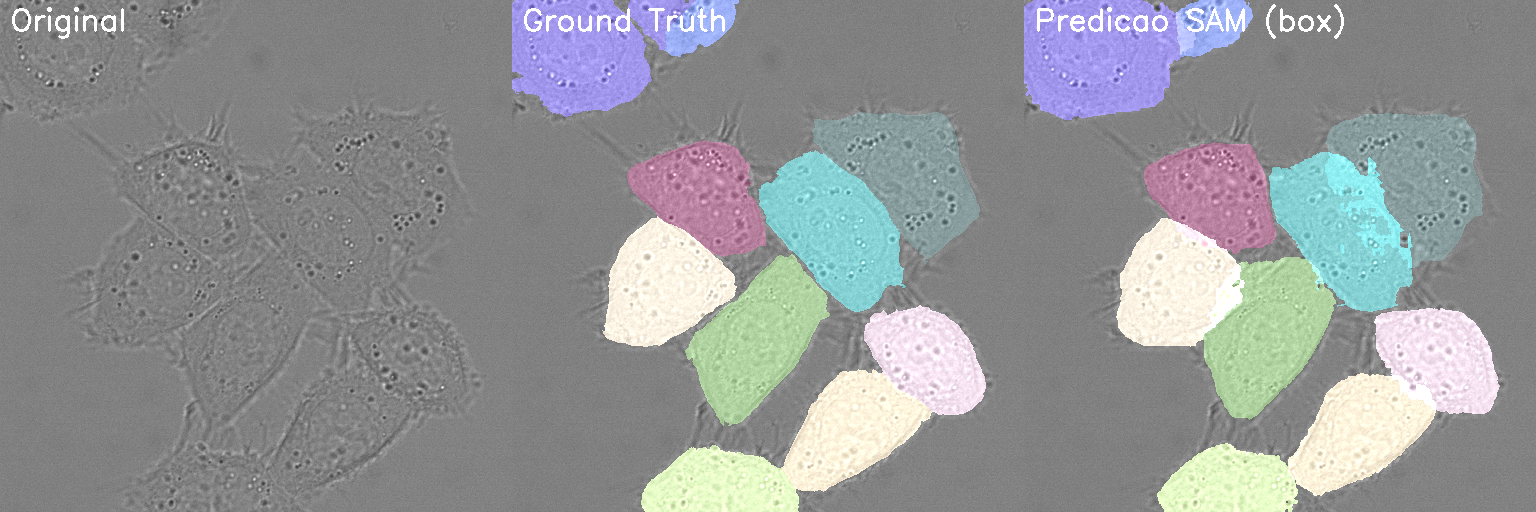

Imagem salva com sucesso: resultado_segmentacao_box.png

--- Visualizando Mode: MASK ---
Encontradas 10 células na imagem. Processando mask...


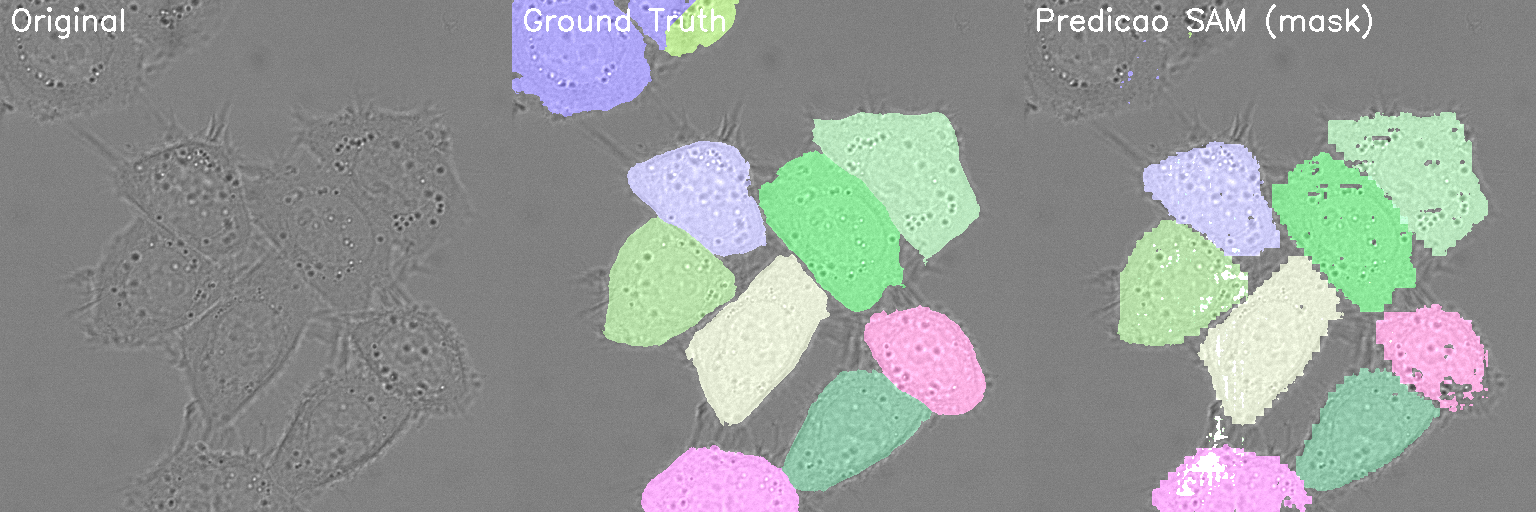

Imagem salva com sucesso: resultado_segmentacao_mask.png


In [16]:
import numpy as np
import torch
import cv2
import os
from PIL import Image
from IPython.display import display

def show_full_segmentation_cv2(test_loader, mode="point"):
    checkpoint_path = f"sam_finetuned_{mode}.pth"
    
    try:
        sam.load_state_dict(torch.load(checkpoint_path, map_location=device))
        sam.eval()
    except FileNotFoundError:
        print(f"Erro: Peso {checkpoint_path} não encontrado. Treine antes.")
        return

    try:
        sample = next(iter(test_loader))
    except StopIteration:
        return
    
    img_np = sample["img"][0].numpy().astype(np.uint8)
    mask_full = sample["mask"][0].numpy() # Máscara com IDs
    
    canvas_gt = img_np.copy()
    canvas_pred = img_np.copy()
    
    obj_ids = np.unique(mask_full)
    obj_ids = obj_ids[obj_ids > 0]
    print(f"Encontradas {len(obj_ids)} células na imagem. Processando {mode}...")

    with torch.no_grad():
        for obj_id in obj_ids:
            # -- Cor Aleatória para esta célula (R, G, B) --
            color = np.random.randint(0, 255, (3,), dtype=int).tolist()
            
            mask_bool_gt = (mask_full == obj_id)
            
            # Cria uma camada de cor apenas onde a máscara existe
            colored_mask_gt = np.zeros_like(canvas_gt)
            colored_mask_gt[mask_bool_gt] = color
            
            canvas_gt = cv2.addWeighted(canvas_gt, 1, colored_mask_gt, 0.5, 0)
            
            binary_mask_input = mask_bool_gt.astype(np.uint8)
            
            logits = sam_forward(img_np, binary_mask_input, mode)
            pred_prob = torch.sigmoid(logits).detach().cpu().numpy().squeeze()
            
            if pred_prob.shape != img_np.shape[:2]:
                pred_prob = cv2.resize(pred_prob, (img_np.shape[1], img_np.shape[0]))
            
            pred_bin = pred_prob > 0.5
            
            colored_mask_pred = np.zeros_like(canvas_pred)
            colored_mask_pred[pred_bin] = color
            
            canvas_pred = cv2.addWeighted(canvas_pred, 1, colored_mask_pred, 0.5, 0)

    h, w, _ = img_np.shape
    combined = np.hstack([img_np, canvas_gt, canvas_pred])
    
    cv2.putText(combined, "Original", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(combined, "Ground Truth", (w + 10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(combined, f"Predicao SAM ({mode})", (2*w + 10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    final_image = Image.fromarray(combined)
    
    display(final_image)
    
    filename = f"resultado_segmentacao_{mode}.png"
    final_image.save(filename)
    print(f"Imagem salva com sucesso: {filename}")

print("--- Visualizando Mode: POINT ---")
show_full_segmentation_cv2(test_loader, "point")

print("\n--- Visualizando Mode: BOX ---")
show_full_segmentation_cv2(test_loader, "box")

print("\n--- Visualizando Mode: MASK ---")
show_full_segmentation_cv2(test_loader, "mask")

## Com Augmentation

In [ ]:
import random
import numpy as np
import torch
import torchvision.transforms.functional as TF
from scipy.ndimage import gaussian_filter, map_coordinates
from typing import Tuple
from PIL import Image
from torch.utils.data import DataLoader


class RandomRotationPair:
    def __init__(self, degrees: float):
        self.degrees = degrees

    def __call__(self, img: torch.Tensor, mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        angle = random.uniform(-self.degrees, self.degrees)
        img_rot = TF.rotate(img, angle, interpolation=TF.InterpolationMode.BILINEAR)

        mask = mask.unsqueeze(0)
        mask_rot = TF.rotate(mask, angle, interpolation=TF.InterpolationMode.NEAREST)
        mask_rot = mask_rot.squeeze(0)
        mask_rot = (mask_rot > 0.5).float()

        return img_rot, mask_rot


class ElasticDeformationPair:
    """
    Elastic deformation similar to the augmentations suggested in the U-Net paper
    (Ronneberger et al., 2015).
    """

    def __init__(self, alpha: float = 50, sigma: float = 4):
        self.alpha = alpha
        self.sigma = sigma

    def __call__(self, img: torch.Tensor, mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Nota: Assume entrada (1, H, W) devido ao squeeze(0)
        img_np = img.squeeze(0).numpy()
        mask_np = mask.squeeze(0).numpy()

        shape = img_np.shape
        dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma=self.sigma, mode="reflect") * self.alpha
        dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma=self.sigma, mode="reflect") * self.alpha

        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = (y + dy).reshape(-1), (x + dx).reshape(-1)

        img_deformed = map_coordinates(img_np, indices, order=1, mode="reflect").reshape(shape)
        mask_deformed = map_coordinates(mask_np, indices, order=0, mode="reflect").reshape(shape)

        img_deformed = torch.from_numpy(img_deformed).unsqueeze(0).float()
        mask_deformed = torch.from_numpy(mask_deformed).unsqueeze(0).float()

        return img_deformed, mask_deformed


class FullAugmentation:
    def __init__(self):
        self.rotate = RandomRotationPair(180)
        self.elastic = ElasticDeformationPair(alpha=50, sigma=4)

    def __call__(self, img: torch.Tensor, mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        img, mask = self.rotate(img, mask)
        img, mask = self.elastic(img, mask)
        mask = (mask > 0.5).float()
        return img, mask



class AugmentedCellDataset(CellDataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        super().__init__(img_dir, mask_dir)
        self.transform = transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        img_pil = Image.open(img_path).convert("L") 
        mask_pil = Image.open(mask_path)

        img_t = torch.tensor(np.array(img_pil)).float().unsqueeze(0)
        mask_t = torch.tensor(np.array(mask_pil)).float().unsqueeze(0)

        if self.transform:
            img_t, mask_t = self.transform(img_t, mask_t)

        img_t = img_t.repeat(3, 1, 1)
        
        img_np = img_t.permute(1, 2, 0).numpy().astype(np.uint8)
        mask_np = mask_t.squeeze(0).numpy().astype(np.uint8)

        return {
            "img": img_np,
            "mask": mask_np
        }

aug_transform = FullAugmentation()
train_dataset_aug = AugmentedCellDataset(images_dir, masks_dir, transform=aug_transform)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=1, shuffle=True)

modes = ["point", "box", "mask"]
print("Iniciando treinamento com Data Augmentation...")
for m in modes:
    sam = sam_model_registry["vit_b"](checkpoint="/kaggle/input/sam-vit-b/pytorch/default/1/sam_vit_b_01ec64.pth").to(device)
    predictor = SamPredictor(sam) 
    
    train_sam(m, train_loader_aug, epochs=4)

print("\nIniciando Avaliação...")
if 'test_loader' not in locals():
    test_dataset = CellDataset("/kaggle/input/cellseg/DIC-C2DH-HeLa/02",
                               "/kaggle/input/cellseg/DIC-C2DH-HeLa/02_ST/SEG")
    test_loader = DataLoader(test_dataset, batch_size=1)

for m in modes:
    evaluate(m, test_loader)

Iniciando treinamento com Data Augmentation...


Training [point] Epoch 4/4: 100%|██████████| 84/84 [00:46<00:00,  1.82it/s, loss=0.462]


Modelo salvo: sam_finetuned_point.pth


Training [box] Epoch 4/4: 100%|██████████| 84/84 [00:45<00:00,  1.83it/s, loss=0.449]


Modelo salvo: sam_finetuned_box.pth


Training [mask] Epoch 4/4: 100%|██████████| 84/84 [00:45<00:00,  1.83it/s, loss=0.162]


Modelo salvo: sam_finetuned_mask.pth

Iniciando Avaliação...


Evaluating point: 100%|██████████| 84/84 [07:39<00:00,  5.47s/it]



Resultados para Modo = point
Total de Células Avaliadas: 988
Mean IoU:  0.0910
Mean Dice: 0.1606
------------------------------


Evaluating box: 100%|██████████| 84/84 [07:38<00:00,  5.45s/it]



Resultados para Modo = box
Total de Células Avaliadas: 988
Mean IoU:  0.6895
Mean Dice: 0.8087
------------------------------


Evaluating mask:   7%|▋         | 6/84 [00:28<06:06,  4.70s/it]

In [ ]:
print("--- Visualizando Mode: POINT ---")
show_full_segmentation_cv2(test_loader, "point")

print("\n--- Visualizando Mode: BOX ---")
show_full_segmentation_cv2(test_loader, "box")

print("\n--- Visualizando Mode: MASK ---")
show_full_segmentation_cv2(test_loader, "mask")

# Pipeline: YOLO V11 Train

In [ ]:
import os
import json
from pathlib import Path
from typing import List, Dict

import cv2
import numpy as np
from PIL import Image
from skimage import measure
from tqdm import tqdm
from ultralytics import YOLO

import torch
import torch.nn.functional as F
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide


# ============================================================
# 0. AUTO-MOUNT DRIVE
# ============================================================

def mount_drive_if_needed():
    if not Path("/content/drive").exists():
        try:
            from google.colab import drive
            drive.mount("/content/drive")
        except Exception:
            pass

mount_drive_if_needed()


# ============================================================
# 1. GLOBAL DIRECTORIES / DEVICE
# ============================================================

DRIVE_ROOT = Path("/content/drive/MyDrive")
HELA_ROOT  = DRIVE_ROOT / "DIC-C2DH-HeLa"
YOLO_ROOT  = DRIVE_ROOT / "HeLa-YOLO11"
RESULTS_DIR = YOLO_ROOT / "results"
SAM_WEIGHTS = DRIVE_ROOT / "weights" / "sam_vit_b_01ec64.pth"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def ensure_dir(path: Path):
    path.mkdir(parents=True, exist_ok=True)


ensure_dir(YOLO_ROOT)
ensure_dir(RESULTS_DIR)
ensure_dir(SAM_WEIGHTS.parent)


# ============================================================
# 2. SAM HELPERS (DOWNLOAD + BUILD)
# ============================================================

SAM_URLS = {
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
}


def ensure_sam_checkpoint(path: Path, model_type: str = "vit_b") -> Path:
    if path.exists():
        return path
    url = SAM_URLS[model_type]
    print(f"[SAM] Downloading {model_type} checkpoint to: {path}")
    torch.hub.download_url_to_file(url, str(path))
    return path


def build_sam(ckpt_path: Path, model_type: str = "vit_b"):
    ckpt_path = ensure_sam_checkpoint(ckpt_path, model_type=model_type)
    print(f"[SAM] Loading SAM {model_type} from {ckpt_path}")
    sam = sam_model_registry[model_type](checkpoint=str(ckpt_path)).to(DEVICE)
    sam.eval()
    sam_transform = ResizeLongestSide(sam.image_encoder.img_size)
    return sam, sam_transform


# ============================================================
# 3. POLYGON UTILITIES
# ============================================================

def mask_to_polygons(mask: np.ndarray) -> List[List[float]]:
    polys = []
    contours = measure.find_contours(mask, 0.5)

    for contour in contours:
        if len(contour) < 6:
            continue
        poly = []
        for y, x in contour:
            poly.append(float(x))
            poly.append(float(y))
        polys.append(poly)

    return polys


def normalize_polygon(poly, w, h):
    return [poly[i] / (w if i % 2 == 0 else h) for i in range(len(poly))]


# ============================================================
# 4. MASK FILE MATCHING
# ============================================================

def find_matching_mask(image_name: str, mask_dir: Path) -> Path:
    base = image_name.replace(".tif", "")   # t000
    num  = base.replace("t", "")           # 000

    candidates = [
        f"man_seg{num}.tif",
        f"seg{num}.tif",
        f"mask{num}.tif",
        f"{base}.tif",
        f"{base}.png",
    ]

    for c in candidates:
        p = mask_dir / c
        if p.exists():
            return p

    raise FileNotFoundError(
        f"[ERROR] No mask for {image_name} in {mask_dir}\nTried: {candidates}"
    )


# ============================================================
# 5. DATASET CONVERSION
# ============================================================

def convert_split(split, img_dir, mask_dir, out_root):
    img_out = out_root / "images" / split
    lbl_out = out_root / "labels" / split

    ensure_dir(img_out)
    ensure_dir(lbl_out)

    files = sorted([f for f in os.listdir(img_dir) if f.endswith(".tif")])
    print(f"[+] Converting {split}: {len(files)} images")

    for fname in tqdm(files, desc=f"Convert {split}"):
        img_path = img_dir / fname
        mask_path = find_matching_mask(fname, mask_dir)

        img = np.array(Image.open(img_path).convert("L"))
        msk = np.array(Image.open(mask_path))

        h, w = img.shape
        Image.fromarray(img).save(img_out / fname.replace(".tif", ".jpg"), quality=95)

        labeled = measure.label(msk)
        ids = np.unique(labeled)[1:]

        txt_path = lbl_out / fname.replace(".tif", ".txt")
        with open(txt_path, "w") as f:
            for inst_id in ids:
                bin_mask = (labeled == inst_id).astype(np.uint8)
                polys = mask_to_polygons(bin_mask)

                for p in polys:
                    norm = normalize_polygon(p, w, h)
                    if len(norm) >= 6:
                        f.write("0 " + " ".join(f"{x:.6f}" for x in norm) + "\n")


def prepare_dataset():
    print("\n[STEP] Preparing YOLO dataset...")
    convert_split("train", HELA_ROOT/"01", HELA_ROOT/"01_ST"/"SEG", YOLO_ROOT)
    convert_split("val",   HELA_ROOT/"02", HELA_ROOT/"02_ST"/"SEG", YOLO_ROOT)


# ============================================================
# 6. WRITE YAML
# ============================================================

def write_yaml():
    y = YOLO_ROOT / "hela.yaml"
    y.write_text(f"""
path: {YOLO_ROOT.as_posix()}
train: images/train
val: images/val

names:
  0: cell
""")
    print(f"[+] YAML written to {y}")
    return y


# ============================================================
# 7. TRAIN YOLO11-SEG
# ============================================================

def train_yolo(yaml_path, epochs=150):
    print("\n[STEP] Training YOLO11-Seg...")
    model = YOLO("yolo11s-seg.pt")
    model.train(
        data=str(yaml_path),
        epochs=epochs,
        imgsz=512,
        batch=8,
        lr0=0.0005,
        mosaic=0.0,
        hsv_s=0.0,
        hsv_v=0.0,
        project=str(YOLO_ROOT),
        name="training"
    )
    best = YOLO_ROOT / "training" / "weights" / "best.pt"
    print(f"[+] Best weights: {best}")
    return best


# ============================================================
# 8. METRICS
# ============================================================

def dice(pred, gt):
    pred = pred.astype(bool)
    gt   = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    return 2 * inter / (pred.sum() + gt.sum() + 1e-7)


# ============================================================
# 9. EVALUATE YOLO ONLY (FIXED)
# ============================================================

def evaluate_yolo_only(weights):
    model = YOLO(str(weights))

    img_dir = HELA_ROOT/"02"
    mask_dir = HELA_ROOT/"02_ST"/"SEG"
    files = sorted([f for f in os.listdir(img_dir) if f.endswith(".tif")])

    ious, dices = [], []

    for fname in tqdm(files, desc="Eval YOLO"):
        img = cv2.imread(str(img_dir/fname), 0)

        mask_path = find_matching_mask(fname, mask_dir)
        mask = cv2.imread(str(mask_path), -1)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        res = model.predict(img_rgb, imgsz=512, verbose=False)[0]

        pred_mask = np.zeros_like(mask, dtype=np.uint8)

        if res.masks is not None:
            for m in res.masks.data:
                m = cv2.resize(m.cpu().numpy(), (mask.shape[1], mask.shape[0]))
                pred_mask[m > 0.5] = 1

        gt = (mask > 0).astype(np.uint8)

        inter = (pred_mask & gt).sum()
        union = (pred_mask | gt).sum()

        ious.append(inter / (union + 1e-7))
        dices.append(dice(pred_mask, gt))

    print(f"[YOLO] IoU={np.mean(ious):.4f} | Dice={np.mean(dices):.4f}")
    return {
        "mean_iou": float(np.mean(ious)),
        "mean_dice": float(np.mean(dices)),
        "n": len(files)
    }


# ============================================================
# 10. YOLO → SAM REFINEMENT
# ============================================================

def sam_refine_from_yolo(img_rgb, yolo_res, sam, sam_transform):
    h, w, _ = img_rgb.shape
    if yolo_res.boxes is None or len(yolo_res.boxes) == 0:
        return np.zeros((h, w), np.uint8)

    # preprocess for SAM
    sam_in = sam_transform.apply_image(img_rgb)
    sam_in = torch.as_tensor(sam_in, device=DEVICE).permute(2,0,1)[None]
    sam_in = sam.preprocess(sam_in)

    with torch.no_grad():
        img_emb = sam.image_encoder(sam_in)

    aggregated = torch.zeros((1,1,h,w), device=DEVICE)
    boxes = yolo_res.boxes.xyxy.cpu().numpy()

    for box in boxes:
        box_np = box[None,:]
        box_trans = sam_transform.apply_boxes(box_np, (h,w))
        box_t = torch.as_tensor(box_trans, device=DEVICE, dtype=torch.float32)

        with torch.no_grad():
            sparse, dense = sam.prompt_encoder(points=None, boxes=box_t, masks=None)
            low_res_mask, _ = sam.mask_decoder(
                image_embeddings=img_emb,
                image_pe=sam.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse,
                dense_prompt_embeddings=dense,
                multimask_output=False,
            )

            up = F.interpolate(low_res_mask, size=(h,w), mode="bilinear", align_corners=False)
            aggregated = torch.maximum(aggregated, up)

    prob = torch.sigmoid(aggregated)[0,0].cpu().numpy()
    return (prob > 0.5).astype(np.uint8)


def evaluate_yolo_sam(weights, sam_ckpt):
    model_yolo = YOLO(str(weights))
    sam, tr = build_sam(sam_ckpt, "vit_b")

    img_dir = HELA_ROOT/"02"
    mask_dir = HELA_ROOT/"02_ST"/"SEG"
    files = sorted([f for f in os.listdir(img_dir) if f.endswith(".tif")])

    ious, dices = [], []

    for fname in tqdm(files, desc="Eval YOLO→SAM"):
        img = cv2.imread(str(img_dir/fname), 0)

        mask_path = find_matching_mask(fname, mask_dir)
        mask = cv2.imread(str(mask_path), -1)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        res = model_yolo.predict(img_rgb, imgsz=512, verbose=False)[0]

        sam_mask = sam_refine_from_yolo(img_rgb, res, sam, tr)
        gt = (mask > 0).astype(np.uint8)

        inter = (sam_mask & gt).sum()
        union = (sam_mask | gt).sum()

        ious.append(inter / (union + 1e-7))
        dices.append(dice(sam_mask, gt))

    print(f"[YOLO→SAM] IoU={np.mean(ious):.4f} | Dice={np.mean(dices):.4f}")
    return {
        "mean_iou": float(np.mean(ious)),
        "mean_dice": float(np.mean(dices)),
        "n": len(files)
    }


# ============================================================
# 11. VISUALIZATION (FIXED)
# ============================================================

def visualize(weights, sam_ckpt):
    ensure_dir(RESULTS_DIR)

    img_dir = HELA_ROOT/"02"
    mask_dir = HELA_ROOT/"02_ST"/"SEG"
    fname = sorted([f for f in os.listdir(img_dir) if f.endswith(".tif")])[0]

    img = cv2.imread(str(img_dir/fname), 0)
    mask_path = find_matching_mask(fname, mask_dir)
    mask = cv2.imread(str(mask_path), -1)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    yolo = YOLO(str(weights))
    res = yolo.predict(img_rgb, imgsz=512, verbose=False)[0]

    yolo_mask = np.zeros_like(mask, np.uint8)
    if res.masks is not None:
        for m in res.masks.data:
            m = cv2.resize(m.cpu().numpy(), (mask.shape[1], mask.shape[0]))
            yolo_mask[m > 0.5] = 1

    sam, tr = build_sam(sam_ckpt, "vit_b")
    sam_mask = sam_refine_from_yolo(img_rgb, res, sam, tr)

    gt = (mask > 0).astype(np.uint8)

    def overlay(img, mask, color):
        out = img.copy()
        out[mask > 0] = (0.5*out[mask>0] + 0.5*np.array(color)).astype(np.uint8)
        return out

    out = np.hstack([
        img_rgb,
        overlay(img_rgb, gt,   [255,0,0]),
        overlay(img_rgb, yolo_mask, [0,255,0]),
        overlay(img_rgb, sam_mask,  [0,0,255]),
    ])

    cv2.imwrite(str(RESULTS_DIR/"viz_yolo_sam.png"), out[:,:,::-1])
    print("[+] Visualization saved.")


# ============================================================
# 12. MAIN
# ============================================================

def main():
    print("\n=== YOLO11 + SAM HeLa Pipeline ===\n")

    prepare_dataset()
    yaml = write_yaml()
    best_yolo = train_yolo(yaml, epochs=150)

    metrics_yolo = evaluate_yolo_only(best_yolo)

    sam_ckpt = ensure_sam_checkpoint(SAM_WEIGHTS)
    metrics_sam = evaluate_yolo_sam(best_yolo, sam_ckpt)

    visualize(best_yolo, sam_ckpt)

    results = {
        "best_yolo": str(best_yolo),
        "sam_checkpoint": str(sam_ckpt),
        "metrics_yolo": metrics_yolo,
        "metrics_yolo_sam": metrics_sam
    }

    (RESULTS_DIR/"results_final.json").write_text(
        json.dumps(results, indent=2)
    )

    print("\n[✓] All done. Results stored in:", RESULTS_DIR)




In [ ]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_models(yolo_path='/content/drive/MyDrive/HeLa-YOLO11/training2/weights/best.pt', sam_path='/content/drive/MyDrive/sam_finetuned_box.pth'):
    yolo = YOLO(str(yolo_path))
    sam = sam_model_registry["vit_b"](checkpoint=str(sam_path)).to(DEVICE)
    sam.eval()
    sam_tr = ResizeLongestSide(sam.image_encoder.img_size)
    return yolo, sam, sam_tr


def sam_refine_box(image_rgb, box_xyxy, sam, sam_tr):
    """
    SAM(image, box_prompt) → mask
    """
    h, w, _ = image_rgb.shape

    # Preprocess image for SAM
    img_sam = sam_tr.apply_image(image_rgb)
    img_sam = torch.as_tensor(img_sam, device=DEVICE).permute(2, 0, 1)[None]
    img_sam = sam.preprocess(img_sam)

    # Encode the image
    with torch.no_grad():
        img_embed = sam.image_encoder(img_sam)

    # Prepare box prompt
    box_np = np.array([box_xyxy])
    box_trans = sam_tr.apply_boxes(box_np, (h, w))
    box_t = torch.as_tensor(box_trans, dtype=torch.float32, device=DEVICE)

    # SAM forward
    with torch.no_grad():
        sparse, dense = sam.prompt_encoder(
            points=None,
            boxes=box_t,
            masks=None
        )

        low_res, _ = sam.mask_decoder(
            image_embeddings=img_embed,
            image_pe=sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse,
            dense_prompt_embeddings=dense,
            multimask_output=False
        )

    # Upsample mask
    up = torch.nn.functional.interpolate(
        low_res, size=(h, w),
        mode="bilinear",
        align_corners=False
    )

    prob = torch.sigmoid(up)[0, 0].cpu().numpy()
    return (prob > 0.5).astype(np.uint8)


def yolo_sam_predict(image_path, yolo, sam, sam_tr):
    """
    Pipeline completo YOLO → SAM(box)
    """
    img = cv2.imread(image_path, 0)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    results = yolo.predict(img_rgb, imgsz=512, verbose=False)[0]
    boxes = results.boxes.xyxy.cpu().numpy()

    masks = []

    for box in boxes:
        mask = sam_refine_box(img_rgb, box, sam, sam_tr)
        masks.append(mask)

    return masks, boxes

yolo, sam, sam_tr = load_models()

masks, boxes = yolo_sam_predict(
    "/content/drive/MyDrive/DIC-C2DH-HeLa/02/t000.tif",
    yolo, sam, sam_tr
)

print("YOLO boxes:", boxes)
print("SAM masks geradas:", len(masks))


In [ ]:

import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from skimage import measure

import torch
from ultralytics import YOLO
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================
# CONFIG
# ============================================

DRIVE_ROOT = Path("/content/drive/MyDrive")
SAM_WEIGHTS = DRIVE_ROOT / "sam_finetuned_box.pth"
YOLO_WEIGHTS = DRIVE_ROOT / "HeLa-YOLO11" / "training" / "weights" / "best.pt"

IMG_DIR = DRIVE_ROOT / "DIC-C2DH-HeLa" / "02"
MASK_DIR = DRIVE_ROOT / "DIC-C2DH-HeLa" / "02_ST" / "SEG"

OUTPUT_VIZ = DRIVE_ROOT / "HeLa-YOLO11" / "results" / "sam_yolo_segmentation.png"


# ============================================
# MÉTRICAS
# ============================================

def iou(a, b):
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return inter / (union + 1e-7)

def dice(a, b):
    inter = np.logical_and(a, b).sum()
    return 2 * inter / (a.sum() + b.sum() + 1e-7)


# ============================================
# LOAD YOLO + SAM
# ============================================

def load_models():
    yolo = YOLO(str(YOLO_WEIGHTS))
    sam = sam_model_registry["vit_b"](checkpoint=str(SAM_WEIGHTS)).to(DEVICE)
    sam.eval()
    tr = ResizeLongestSide(sam.image_encoder.img_size)
    return yolo, sam, tr


# ============================================
# SAM(box) → MASK
# ============================================

def sam_from_box(image_rgb, box, sam, tr):
    h, w, _ = image_rgb.shape

    # preprocess
    img_sam = tr.apply_image(image_rgb)
    img_sam = torch.as_tensor(img_sam, device=DEVICE).permute(2,0,1)[None]
    img_sam = sam.preprocess(img_sam)

    with torch.no_grad():
        emb = sam.image_encoder(img_sam)

    # box
    box = box.astype(float)
    box_sam = tr.apply_boxes(box[None], (h, w))
    box_t = torch.as_tensor(box_sam, device=DEVICE, dtype=torch.float32)

    with torch.no_grad():
        sparse, dense = sam.prompt_encoder(
            points=None,
            boxes=box_t,
            masks=None
        )

        low_res, _ = sam.mask_decoder(
            image_embeddings=emb,
            image_pe=sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse,
            dense_prompt_embeddings=dense,
            multimask_output=False
        )

    # upsample
    up = torch.nn.functional.interpolate(
        low_res,
        size=(h, w),
        mode="bilinear",
        align_corners=False
    )

    prob = torch.sigmoid(up)[0,0].cpu().numpy()
    return (prob > 0.5).astype(np.uint8)


# ============================================
# MATCH GT INSTANCE → MELHOR YOLO BOX
# ============================================

def best_yolo_box_for_gt(gt_mask, yolo_boxes):
    best_i = -1
    best_score = 0

    for i, box in enumerate(yolo_boxes):
        x1, y1, x2, y2 = map(int, box)
        box_mask = np.zeros_like(gt_mask)
        box_mask[y1:y2, x1:x2] = 1

        score = iou(gt_mask, box_mask)
        if score > best_score:
            best_score = score
            best_i = i

    return best_i


# ============================================
# AVALIAÇÃO + VIZ FINAL
# ============================================

def evaluate_yolo_sam():
    yolo, sam, tr = load_models()

    files = sorted([f for f in os.listdir(IMG_DIR) if f.endswith(".tif")])

    all_iou = []
    all_dice = []
    first_image_viz = None

    for fname in tqdm(files, desc="YOLO → SAM Evaluation"):
        # load image
        img = cv2.imread(str(IMG_DIR/fname), 0)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # load GT
        gt_path1 = MASK_DIR / f"man_seg{fname[1:]}"
        gt_path2 = MASK_DIR / f"seg{fname[1:]}"
        gt_path3 = MASK_DIR / fname

        if gt_path1.exists(): gt = cv2.imread(str(gt_path1), -1)
        elif gt_path2.exists(): gt = cv2.imread(str(gt_path2), -1)
        elif gt_path3.exists(): gt = cv2.imread(str(gt_path3), -1)
        else: continue

        gt_labeled = measure.label(gt)

        # YOLO boxes
        yolo_res = yolo.predict(img_rgb, imgsz=512, verbose=False)[0]
        if yolo_res.boxes is None or len(yolo_res.boxes) == 0:
            continue

        yolo_boxes = yolo_res.boxes.xyxy.cpu().numpy()

        # == evaluation by instance ==
        obj_ids = np.unique(gt_labeled)[1:]  # skip 0

        for oid in obj_ids:
            mask_gt = (gt_labeled == oid)

            bidx = best_yolo_box_for_gt(mask_gt, yolo_boxes)
            if bidx < 0:
                # YOLO não detectou → erro
                all_iou.append(0)
                all_dice.append(0)
                continue

            box = yolo_boxes[bidx]

            mask_pred = sam_from_box(img_rgb, box, sam, tr)

            all_iou.append(iou(mask_gt, mask_pred))
            all_dice.append(dice(mask_gt, mask_pred))

        # salvar visualização da primeira imagem
        if first_image_viz is None:
            canvas = img_rgb.copy()

            for i, box in enumerate(yolo_boxes):
                mask_pred = sam_from_box(img_rgb, box, sam, tr)
                color = np.random.randint(0, 255, (3,), dtype=np.uint8)
                canvas[mask_pred > 0] = 0.5 * canvas[mask_pred > 0] + 0.5 * color

            first_image_viz = canvas

    # salvar visualização
    if first_image_viz is not None:
        cv2.imwrite(str(OUTPUT_VIZ), first_image_viz[..., ::-1])
        print(f"\n[+] Segmentation visualization saved to:\n{OUTPUT_VIZ}")

    print("\n===============================")
    print(" YOLO → SAM RESULTS (INSTANCE) ")
    print("===============================")
    print(f"Total cells evaluated: {len(all_iou)}")
    print(f"Mean IoU  = {np.mean(all_iou):.4f}")
    print(f"Mean Dice = {np.mean(all_dice):.4f}")

    return {
        "instances": len(all_iou),
        "mean_iou": float(np.mean(all_iou)),
        "mean_dice": float(np.mean(all_dice))
    }


if __name__ == "__main__":
    metrics = evaluate_yolo_sam()
    print("\nFinal metrics:", metrics)


In [ ]:

import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from skimage import measure

import torch
from ultralytics import YOLO
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================
# CONFIG
# ============================================

DRIVE_ROOT = Path("/content/drive/MyDrive")

# ---- SAM paths ----
SAM_FINETUNED_WEIGHTS = DRIVE_ROOT / "sam_finetuned_box.pth"          # your finetuned
SAM_BASE_WEIGHTS      = DRIVE_ROOT / "weights" / "sam_vit_b_01ec64.pth"  # base/original vit_b

# ---- YOLO paths ----
YOLO_WEIGHTS = DRIVE_ROOT / "HeLa-YOLO11" / "training" / "weights" / "best.pt"

# ---- DATA ----
IMG_DIR  = DRIVE_ROOT / "DIC-C2DH-HeLa" / "02"
MASK_DIR = DRIVE_ROOT / "DIC-C2DH-HeLa" / "02_ST" / "SEG"

# ---- OUTPUTS ----
OUTPUT_VIZ_IMAGE = DRIVE_ROOT / "HeLa-YOLO11" / "results" / "sam_yolo_viz_qualitative.png"
OUTPUT_VIZ_METRICS = DRIVE_ROOT / "HeLa-YOLO11" / "results" / "sam_yolo_viz_metrics.png"


# ============================================
# MÉTRICAS
# ============================================

def iou(a, b):
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return inter / (union + 1e-7)

def dice(a, b):
    inter = np.logical_and(a, b).sum()
    return 2 * inter / (a.sum() + b.sum() + 1e-7)


# ============================================
# LOAD YOLO + SAM
# ============================================

def load_yolo():
    return YOLO(str(YOLO_WEIGHTS))

def load_sam(weights_path):
    sam = sam_model_registry["vit_b"](checkpoint=str(weights_path)).to(DEVICE)
    sam.eval()
    tr = ResizeLongestSide(sam.image_encoder.img_size)
    return sam, tr


# ============================================
# SAM(box) → MASK
# ============================================

def sam_from_box(image_rgb, box, sam, tr):
    """
    Dado image_rgb (H,W,3) e uma box xyxy (x1,y1,x2,y2),
    retorna uma máscara binária (H,W) usando SAM.
    """
    h, w, _ = image_rgb.shape

    # preprocess
    img_sam = tr.apply_image(image_rgb)
    img_sam = torch.as_tensor(img_sam, device=DEVICE).permute(2, 0, 1)[None]
    img_sam = sam.preprocess(img_sam)

    with torch.no_grad():
        emb = sam.image_encoder(img_sam)

    # box
    box = box.astype(float)
    box_sam = tr.apply_boxes(box[None], (h, w))
    box_t = torch.as_tensor(box_sam, device=DEVICE, dtype=torch.float32)

    with torch.no_grad():
        sparse, dense = sam.prompt_encoder(
            points=None,
            boxes=box_t,
            masks=None
        )

        low_res, _ = sam.mask_decoder(
            image_embeddings=emb,
            image_pe=sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse,
            dense_prompt_embeddings=dense,
            multimask_output=False
        )

    # upsample
    up = torch.nn.functional.interpolate(
        low_res,
        size=(h, w),
        mode="bilinear",
        align_corners=False
    )

    prob = torch.sigmoid(up)[0, 0].cpu().numpy()
    return (prob > 0.5).astype(np.uint8)


# ============================================
# MATCH GT INSTANCE → MELHOR YOLO BOX
# ============================================

def best_yolo_box_for_gt(gt_mask, yolo_boxes):
    best_i = -1
    best_score = 0.0

    for i, box in enumerate(yolo_boxes):
        x1, y1, x2, y2 = map(int, box)
        box_mask = np.zeros_like(gt_mask, dtype=np.uint8)
        box_mask[y1:y2, x1:x2] = 1

        score = iou(gt_mask, box_mask)
        if score > best_score:
            best_score = score
            best_i = i

    return best_i


# ============================================
# viz-STYLE QUALITATIVE FIGURE
# ============================================

def make_viz_qualitative_figure(viz, save_path):
    """
    Cria figura com:
    [Raw] [GT] [YOLO boxes] [Base SAM] [Finetuned SAM]
    """
    img_rgb     = viz["img_rgb"]
    gt_labeled  = viz["gt_labeled"]
    yolo_boxes  = viz["yolo_boxes"]
    pred_base   = viz["pred_base"]
    pred_ft     = viz["pred_ft"]

    # Normalize GT to a nice colormap
    gt_norm = gt_labeled.astype(np.float32)
    if gt_norm.max() > 0:
        gt_norm = gt_norm / gt_norm.max()

    plt.figure(figsize=(18, 4), dpi=300)

    # 1) Raw image
    plt.subplot(1, 5, 1)
    plt.imshow(img_rgb[..., 0], cmap="gray")
    plt.title("Raw DIC image", fontsize=10)
    plt.axis("off")

    # 2) Ground truth instance mask
    plt.subplot(1, 5, 2)
    plt.imshow(img_rgb[..., 0], cmap="gray")
    plt.imshow(gt_norm, alpha=0.35, cmap="nipy_spectral")
    plt.title("Ground truth", fontsize=10)
    plt.axis("off")

    # 3) YOLO boxes
    plt.subplot(1, 5, 3)
    plt.imshow(img_rgb[..., 0], cmap="gray")
    ax = plt.gca()
    for (x1, y1, x2, y2) in yolo_boxes:
        rect = Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            linewidth=1.2
        )
        ax.add_patch(rect)
    plt.title("YOLO bounding boxes", fontsize=10)
    plt.axis("off")

    # 4) Base SAM (untrained on HeLa)
    plt.subplot(1, 5, 4)
    plt.imshow(img_rgb[..., 0], cmap="gray")
    plt.imshow(pred_base, alpha=0.35)
    plt.title("Base SAM + YOLO prompt", fontsize=10)
    plt.axis("off")

    # 5) Finetuned SAM
    plt.subplot(1, 5, 5)
    plt.imshow(img_rgb[..., 0], cmap="gray")
    plt.imshow(pred_ft, alpha=0.35)
    plt.title("Finetuned SAM + YOLO prompt", fontsize=10)
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(str(save_path), bbox_inches="tight")
    plt.close()

    print(f"[+] viz-style qualitative figure saved to:\n    {save_path}")


# ============================================
# viz-STYLE METRIC PLOTS
# ============================================

def make_viz_metric_plots(metrics, save_path):
    """
    Plota boxplots de IoU e Dice para:
      - Base SAM
      - Finetuned SAM
    """
    base_iou  = np.array(metrics["base"]["iou"])
    ft_iou    = np.array(metrics["finetuned"]["iou"])
    base_dice = np.array(metrics["base"]["dice"])
    ft_dice   = np.array(metrics["finetuned"]["dice"])

    plt.figure(figsize=(10, 4), dpi=300)

    # ---- IoU boxplot
    plt.subplot(1, 2, 1)
    plt.boxplot(
        [base_iou, ft_iou],
        labels=["Base SAM", "Finetuned SAM"],
        showfliers=False
    )
    plt.ylabel("IoU")
    plt.title("Instance-level IoU distribution")

    # ---- Dice boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(
        [base_dice, ft_dice],
        labels=["Base SAM", "Finetuned SAM"],
        showfliers=False
    )
    plt.ylabel("Dice")
    plt.title("Instance-level Dice distribution")

    plt.tight_layout()
    plt.savefig(str(save_path), bbox_inches="tight")
    plt.close()

    print(f"[+] viz-style metric plots saved to:\n    {save_path}")


# ============================================
# AVALIAÇÃO: BASE SAM vs FINETUNED SAM
# ============================================

def evaluate_yolo_sam_compare():
    """
    Compara:
      - SAM base (não treinado em HeLa)
      - SAM finetuned
    Ambos usando YOLO boxes como prompts.
    Métricas por instância (IoU, Dice) e visualizações estilo viz.
    """
    # Load models
    yolo = load_yolo()
    sam_base, tr_base = load_sam(SAM_BASE_WEIGHTS)
    sam_ft,   tr_ft   = load_sam(SAM_FINETUNED_WEIGHTS)

    files = sorted([f for f in os.listdir(IMG_DIR) if f.endswith(".tif")])

    metrics = {
        "base": {
            "iou": [],
            "dice": []
        },
        "finetuned": {
            "iou": [],
            "dice": []
        }
    }

    qualitative_viz = None  # store data for one nice qualitative example

    for fname in tqdm(files, desc="YOLO → SAM Evaluation (Base vs Finetuned)"):
        # Load image
        img = cv2.imread(str(IMG_DIR / fname), 0)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Load GT (try multiple naming conventions)
        gt_path1 = MASK_DIR / f"man_seg{fname[1:]}"
        gt_path2 = MASK_DIR / f"seg{fname[1:]}"
        gt_path3 = MASK_DIR / fname

        if gt_path1.exists():
            gt = cv2.imread(str(gt_path1), -1)
        elif gt_path2.exists():
            gt = cv2.imread(str(gt_path2), -1)
        elif gt_path3.exists():
            gt = cv2.imread(str(gt_path3), -1)
        else:
            continue

        if gt is None:
            continue

        gt_labeled = measure.label(gt)

        # YOLO boxes
        yolo_res = yolo.predict(img_rgb, imgsz=512, verbose=False)[0]
        if yolo_res.boxes is None or len(yolo_res.boxes) == 0:
            continue

        yolo_boxes = yolo_res.boxes.xyxy.cpu().numpy()

        # ---- Métrica por instância ----
        obj_ids = np.unique(gt_labeled)[1:]  # skip background 0

        for oid in obj_ids:
            mask_gt = (gt_labeled == oid)

            bidx = best_yolo_box_for_gt(mask_gt, yolo_boxes)
            if bidx < 0:
                # YOLO não detectou → erro (0 IoU/Dice)
                metrics["base"]["iou"].append(0.0)
                metrics["base"]["dice"].append(0.0)
                metrics["finetuned"]["iou"].append(0.0)
                metrics["finetuned"]["dice"].append(0.0)
                continue

            box = yolo_boxes[bidx]

            # SAM base
            mask_base = sam_from_box(img_rgb, box, sam_base, tr_base)
            # SAM finetuned
            mask_ft   = sam_from_box(img_rgb, box, sam_ft, tr_ft)

            metrics["base"]["iou"].append(iou(mask_gt, mask_base))
            metrics["base"]["dice"].append(dice(mask_gt, mask_base))
            metrics["finetuned"]["iou"].append(iou(mask_gt, mask_ft))
            metrics["finetuned"]["dice"].append(dice(mask_gt, mask_ft))

        # ---- Guardar uma imagem para visualização bonita ----
        if qualitative_viz is None and len(yolo_boxes) > 0:
            # union of all predicted masks for nicer overlay
            union_base = np.zeros_like(gt, dtype=np.uint8)
            union_ft   = np.zeros_like(gt, dtype=np.uint8)
            for box in yolo_boxes:
                union_base = np.logical_or(
                    union_base,
                    sam_from_box(img_rgb, box, sam_base, tr_base)
                )
                union_ft = np.logical_or(
                    union_ft,
                    sam_from_box(img_rgb, box, sam_ft, tr_ft)
                )

            qualitative_viz = {
                "img_rgb": img_rgb,
                "gt_labeled": gt_labeled,
                "yolo_boxes": yolo_boxes,
                "pred_base": union_base.astype(np.uint8),
                "pred_ft": union_ft.astype(np.uint8)
            }

    # ============================================
    # PRINT SUMMARY
    # ============================================

    n_instances = len(metrics["base"]["iou"])
    base_iou_mean  = float(np.mean(metrics["base"]["iou"])) if n_instances > 0 else 0.0
    base_dice_mean = float(np.mean(metrics["base"]["dice"])) if n_instances > 0 else 0.0
    ft_iou_mean    = float(np.mean(metrics["finetuned"]["iou"])) if n_instances > 0 else 0.0
    ft_dice_mean   = float(np.mean(metrics["finetuned"]["dice"])) if n_instances > 0 else 0.0

    print("\n==============================================")
    print("  YOLO → SAM RESULTS (INSTANCE-LEVEL, GT)     ")
    print("==============================================")
    print(f"Total GT cells evaluated: {n_instances}")
    print("----------------------------------------------")
    print("Base SAM (untrained for HeLa):")
    print(f"  Mean IoU  = {base_iou_mean:.4f}")
    print(f"  Mean Dice = {base_dice_mean:.4f}")
    print("----------------------------------------------")
    print("Finetuned SAM:")
    print(f"  Mean IoU  = {ft_iou_mean:.4f}")
    print(f"  Mean Dice = {ft_dice_mean:.4f}")
    print("==============================================")

    # ============================================
    # VISUALIZAÇÕES viz
    # ============================================

    if qualitative_viz is not None:
        make_viz_qualitative_figure(qualitative_viz, OUTPUT_VIZ_IMAGE)

    if n_instances > 0:
        make_viz_metric_plots(metrics, OUTPUT_VIZ_METRICS)

    # retorno bruto para log / JSON
    return {
        "instances": n_instances,
        "base": {
            "mean_iou": base_iou_mean,
            "mean_dice": base_dice_mean
        },
        "finetuned": {
            "mean_iou": ft_iou_mean,
            "mean_dice": ft_dice_mean
        }
    }


if __name__ == "__main__":
    results = evaluate_yolo_sam_compare()
    print("\nFinal metrics:", results)


# Tests YOLOV11 Pipeline: viz

In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from skimage import measure
from scipy.ndimage import binary_dilation, binary_erosion, distance_transform_edt

import torch
import torch.nn.functional as F

from ultralytics import YOLO
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.ndimage import distance_transform_edt
from scipy.spatial.distance import directed_hausdorff
from scipy.spatial import Voronoi, voronoi_plot_2d
import pandas as pd

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


###############################################################
# CONFIG
###############################################################

DRIVE_ROOT = Path("/content/drive/MyDrive")

SAM_FINETUNED_WEIGHTS = DRIVE_ROOT / "sam_finetuned_box.pth"
SAM_BASE_WEIGHTS      = DRIVE_ROOT / "weights" / "sam_vit_b_01ec64.pth"

YOLO_WEIGHTS = DRIVE_ROOT / "HeLa-YOLO11" / "training" / "weights" / "best.pt"

IMG_DIR  = DRIVE_ROOT / "DIC-C2DH-HeLa" / "02"
MASK_DIR = DRIVE_ROOT / "DIC-C2DH-HeLa" / "02_ST" / "SEG"

OUTPUT_DIR = DRIVE_ROOT / "HeLa-YOLO11" / "results"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


###############################################################
# METRICS
###############################################################

def iou(a, b):
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return inter / (union + 1e-7)

def dice(a, b):
    inter = np.logical_and(a, b).sum()
    return 2 * inter / (a.sum() + b.sum() + 1e-7)

###############################################################
# BOUNDARY EXTRACTION + BOUNDARY METRICS
###############################################################

def get_boundary(mask, width=1):
    dil = binary_dilation(mask, iterations=width)
    ero = binary_erosion(mask, iterations=width)
    boundary = np.logical_and(dil, np.logical_not(ero))
    return boundary.astype(np.uint8)

def boundary_f1(gt_mask, pred_mask, tolerance=2):
    gt_b = get_boundary(gt_mask)
    pr_b = get_boundary(pred_mask)

    if pr_b.sum() == 0 or gt_b.sum() == 0:
        return 0.0

    dt_gt = distance_transform_edt(1 - gt_b)
    dt_pr = distance_transform_edt(1 - pr_b)

    pr_match = pr_b * (dt_gt <= tolerance)
    gt_match = gt_b * (dt_pr <= tolerance)

    precision = pr_match.sum() / (pr_b.sum() + 1e-7)
    recall    = gt_match.sum() / (gt_b.sum() + 1e-7)

    if precision + recall == 0:
        return 0.0

    return 2 * precision * recall / (precision + recall + 1e-7)

def hausdorff_distance(gt_mask, pred_mask):
    gt_pts = np.column_stack(np.where(gt_mask > 0))
    pr_pts = np.column_stack(np.where(pred_mask > 0))

    if len(gt_pts) == 0 or len(pr_pts) == 0:
        return np.inf

    hd1 = directed_hausdorff(gt_pts, pr_pts)[0]
    hd2 = directed_hausdorff(pr_pts, gt_pts)[0]
    return max(hd1, hd2)


###############################################################
# LOAD MODELS
###############################################################

def load_yolo():
    return YOLO(str(YOLO_WEIGHTS))

def load_sam(weights_path):
    sam = sam_model_registry["vit_b"](checkpoint=str(weights_path)).to(DEVICE)
    sam.eval()
    tr = ResizeLongestSide(sam.image_encoder.img_size)
    return sam, tr


###############################################################
# SAM FROM BOX
###############################################################

def sam_from_box(image_rgb, box, sam, tr):
    h, w, _ = image_rgb.shape

    img_sam = tr.apply_image(image_rgb)
    img_sam = torch.as_tensor(img_sam, device=DEVICE).permute(2,0,1)[None]
    img_sam = sam.preprocess(img_sam)

    with torch.no_grad():
        emb = sam.image_encoder(img_sam)

    box = box.astype(float)
    box_sam = tr.apply_boxes(box[None], (h, w))
    box_t = torch.as_tensor(box_sam, device=DEVICE, dtype=torch.float32)

    with torch.no_grad():
        sparse, dense = sam.prompt_encoder(points=None, boxes=box_t, masks=None)
        low_res, _ = sam.mask_decoder(
            image_embeddings=emb,
            image_pe=sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse,
            dense_prompt_embeddings=dense,
            multimask_output=False
        )

    up = F.interpolate(low_res, size=(h, w), mode="bilinear", align_corners=False)
    prob = torch.sigmoid(up)[0,0].cpu().numpy()
    return (prob > 0.5).astype(np.uint8)


def best_yolo_box_for_gt(gt_mask, yolo_boxes):
    best_idx = -1
    best_score = 0.0

    for i, box in enumerate(yolo_boxes):
        x1, y1, x2, y2 = map(int, box)
        box_mask = np.zeros_like(gt_mask)
        box_mask[y1:y2, x1:x2] = 1
        score = iou(gt_mask, box_mask)
        if score > best_score:
            best_score = score
            best_idx = i
    return best_idx


###############################################################
# PUBLICATION-GRADE PLOTS
###############################################################

# =============================================================
# A. Boundary & Contour Visualizations
# =============================================================

def plot_boundary_overlay(img_rgb, gt_mask, pred_base, pred_ft, save_path):
    gt_b = get_boundary(gt_mask)
    b_b  = get_boundary(pred_base)
    f_b  = get_boundary(pred_ft)

    plt.figure(figsize=(15,4), dpi=300)

    plt.subplot(1,4,1)
    plt.imshow(img_rgb[...,0], cmap="gray")
    plt.title("Raw")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(img_rgb[...,0], cmap="gray")
    plt.imshow(gt_b, cmap="autumn", alpha=0.7)
    plt.title("GT Boundary")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(img_rgb[...,0], cmap="gray")
    plt.imshow(b_b, cmap="Reds", alpha=0.7)
    plt.title("Base SAM Boundary")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(img_rgb[...,0], cmap="gray")
    plt.imshow(f_b, cmap="cool", alpha=0.7)
    plt.title("Finetuned SAM Boundary")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(str(save_path))
    plt.close()


def plot_boundary_error(img_rgb, gt_mask, pred_mask, save_path):
    gt_b = get_boundary(gt_mask)
    pr_b = get_boundary(pred_mask)
    dist = distance_transform_edt(1 - gt_b)

    plt.figure(figsize=(8,6), dpi=300)
    plt.imshow(img_rgb[...,0], cmap="gray")
    plt.imshow(dist, cmap="turbo", alpha=0.6)
    plt.imshow(pr_b, cmap="gray_r", alpha=0.9)
    plt.title("Boundary Distance Heatmap")
    plt.axis("off")
    plt.colorbar(label="Distance to GT boundary (px)")
    plt.savefig(str(save_path))
    plt.close()


def plot_contour_comparison(img_rgb, gt_mask, pred_base, pred_ft, save_path):
    gt_c = measure.find_contours(gt_mask, 0.5)
    b_c  = measure.find_contours(pred_base, 0.5)
    f_c  = measure.find_contours(pred_ft, 0.5)

    plt.figure(figsize=(7,7), dpi=300)
    plt.imshow(img_rgb[...,0], cmap="gray")

    for c in gt_c:
        plt.plot(c[:,1], c[:,0], "y", linewidth=1.3)

    for c in b_c:
        plt.plot(c[:,1], c[:,0], "r", linewidth=1.0, alpha=0.6)

    for c in f_c:
        plt.plot(c[:,1], c[:,0], "c", linewidth=1.0, alpha=0.6)

    plt.axis("off")
    plt.title("Contours: GT / Base / Finetuned")
    plt.savefig(str(save_path))
    plt.close()


def plot_signed_distance_map(gt_mask, pred_mask, save_path):
    dt_gt = distance_transform_edt(gt_mask == 0)
    dt_pr = distance_transform_edt(pred_mask == 0)
    signed = dt_pr - dt_gt

    plt.figure(figsize=(8,6), dpi=300)
    plt.imshow(signed, cmap="seismic", vmin=-10, vmax=10)
    plt.title("Signed Distance Error")
    plt.axis("off")
    plt.colorbar()
    plt.savefig(str(save_path))
    plt.close()



def scatter_iou_dice(metrics, save_path):
    plt.figure(figsize=(7,6), dpi=300)
    plt.scatter(metrics["base"]["iou"], metrics["base"]["dice"], s=8, alpha=0.5, label="Base")
    plt.scatter(metrics["finetuned"]["iou"], metrics["finetuned"]["dice"], s=8, alpha=0.5, label="Finetuned")
    plt.xlabel("IoU")
    plt.ylabel("Dice")
    plt.title("IoU vs Dice")
    plt.legend()
    plt.savefig(str(save_path))
    plt.close()


def scatter_iou_bf(metrics, save_path):
    plt.figure(figsize=(7,6), dpi=300)
    plt.scatter(metrics["base"]["iou"], metrics["base"]["bf"], s=8, alpha=0.5, label="Base")
    plt.scatter(metrics["finetuned"]["iou"], metrics["finetuned"]["bf"], s=8, alpha=0.5, label="Finetuned")
    plt.xlabel("IoU")
    plt.ylabel("Boundary F1")
    plt.title("IoU vs Boundary F1")
    plt.legend()
    plt.savefig(str(save_path))
    plt.close()


def scatter_bf_hd(metrics, save_path):
    plt.figure(figsize=(7,6), dpi=300)
    plt.scatter(metrics["base"]["hd"], metrics["base"]["bf"], s=8, alpha=0.5, label="Base")
    plt.scatter(metrics["finetuned"]["hd"], metrics["finetuned"]["bf"], s=8, alpha=0.5, label="Finetuned")
    plt.xlabel("Hausdorff Distance")
    plt.ylabel("Boundary F1")
    plt.title("Boundary F1 vs Hausdorff")
    plt.legend()
    plt.savefig(str(save_path))
    plt.close()


def plot_metric_densities(metrics, save_path):
    plt.figure(figsize=(12,4), dpi=300)

    plt.subplot(1,3,1)
    sns.kdeplot(metrics["base"]["iou"],  label="Base")
    sns.kdeplot(metrics["finetuned"]["iou"], label="Finetuned")
    plt.title("IoU Density")

    plt.subplot(1,3,2)
    sns.kdeplot(metrics["base"]["dice"], label="Base")
    sns.kdeplot(metrics["finetuned"]["dice"], label="Finetuned")
    plt.title("Dice Density")

    plt.subplot(1,3,3)
    sns.kdeplot(metrics["base"]["bf"], label="Base")
    sns.kdeplot(metrics["finetuned"]["bf"], label="Finetuned")
    plt.title("Boundary F1 Density")

    plt.legend()
    plt.tight_layout()
    plt.savefig(str(save_path))
    plt.close()


def violin_metrics(metrics, save_path):
    df = pd.DataFrame({
        "IoU": metrics["base"]["iou"] + metrics["finetuned"]["iou"],
        "Dice": metrics["base"]["dice"] + metrics["finetuned"]["dice"],
        "BF": metrics["base"]["bf"] + metrics["finetuned"]["bf"],
        "Model": ["Base"]*len(metrics["base"]["iou"]) + ["Finetuned"]*len(metrics["finetuned"]["iou"])
    })

    plt.figure(figsize=(10,5), dpi=300)
    plt.subplot(1,3,1)
    sns.violinplot(data=df, x="Model", y="IoU")

    plt.subplot(1,3,2)
    sns.violinplot(data=df, x="Model", y="Dice")

    plt.subplot(1,3,3)
    sns.violinplot(data=df, x="Model", y="BF")

    plt.tight_layout()
    plt.savefig(str(save_path))
    plt.close()



def plot_size_distribution(gt_labeled, pred_base, pred_ft, save_path):
    def areas(lbl):
        return [np.sum(lbl == x) for x in np.unique(lbl)[1:]]

    a_gt = areas(gt_labeled)
    a_b = areas(measure.label(pred_base))
    a_f = areas(measure.label(pred_ft))

    plt.figure(figsize=(8,5), dpi=300)
    plt.hist(a_gt, bins=25, alpha=0.6, label="GT")
    plt.hist(a_b,  bins=25, alpha=0.6, label="Base")
    plt.hist(a_f,  bins=25, alpha=0.6, label="Finetuned")
    plt.xlabel("Cell area (px)")
    plt.ylabel("Count")
    plt.title("Cell Size Distribution")
    plt.legend()
    plt.savefig(str(save_path))
    plt.close()


def plot_eccentricity(gt_labeled, pred_base, pred_ft, save_path):
    def ecc(lbl):
        return [p.eccentricity for p in measure.regionprops(lbl)]

    e_gt = ecc(gt_labeled)
    e_b = ecc(measure.label(pred_base))
    e_f = ecc(measure.label(pred_ft))

    plt.figure(figsize=(8,5), dpi=300)
    plt.boxplot([e_gt, e_b, e_f], labels=["GT", "Base", "Finetuned"])
    plt.ylabel("Eccentricity")
    plt.title("Eccentricity Comparison")
    plt.savefig(str(save_path))
    plt.close()


def plot_perimeter_vs_area(gt_labeled, pred_base, pred_ft, save_path):
    def PA(lbl):
        props = measure.regionprops(lbl)
        return [p.area for p in props], [p.perimeter for p in props]

    a_gt, p_gt = PA(gt_labeled)
    a_b,  p_b  = PA(measure.label(pred_base))
    a_f,  p_f  = PA(measure.label(pred_ft))

    plt.figure(figsize=(7,6), dpi=300)
    plt.scatter(a_gt, p_gt, s=6, alpha=0.5, label="GT")
    plt.scatter(a_b,  p_b,  s=6, alpha=0.5, label="Base")
    plt.scatter(a_f,  p_f,  s=6, alpha=0.5, label="Finetuned")
    plt.xlabel("Area")
    plt.ylabel("Perimeter")
    plt.legend()
    plt.title("Area vs Perimeter")
    plt.savefig(str(save_path))
    plt.close()


def plot_voronoi_from_instances(gt_labeled, save_path):
    centers = np.array([p.centroid for p in measure.regionprops(gt_labeled)])
    if len(centers) < 3:
        return

    vor = Voronoi(centers)

    plt.figure(figsize=(6,6), dpi=300)
    voronoi_plot_2d(vor, show_vertices=False, line_colors="white", line_width=1)
    plt.scatter(centers[:,1], centers[:,0], s=5, color="red")
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.title("Cell Neighborhood Graph")
    plt.savefig(str(save_path))
    plt.close()


def evaluate():
    yolo = load_yolo()
    sam_base, tr_base = load_sam(SAM_BASE_WEIGHTS)
    sam_ft,   tr_ft   = load_sam(SAM_FINETUNED_WEIGHTS)

    files = sorted([f for f in os.listdir(IMG_DIR) if f.endswith(".tif")])

    metrics = {
        "base":      {"iou": [], "dice": [], "bf": [], "hd": []},
        "finetuned": {"iou": [], "dice": [], "bf": [], "hd": []}
    }

    qualitative = None

    for fname in tqdm(files, desc="Evaluating"):
        img = cv2.imread(str(IMG_DIR / fname), 0)
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        gt_candidates = [
            MASK_DIR / f"man_seg{fname[1:]}",
            MASK_DIR / f"seg{fname[1:]}",
            MASK_DIR / fname
        ]

        gt = None
        for p in gt_candidates:
            if p.exists():
                gt = cv2.imread(str(p), -1)
                break
        if gt is None:
            continue

        gt_lbl = measure.label(gt)

        res = yolo.predict(img_rgb, imgsz=512, verbose=False)[0]
        if res.boxes is None or len(res.boxes) == 0:
            continue

        boxes = res.boxes.xyxy.cpu().numpy()
        obj_ids = np.unique(gt_lbl)[1:]

        for oid in obj_ids:
            mask_gt = (gt_lbl == oid)

            idx = best_yolo_box_for_gt(mask_gt, boxes)
            if idx < 0:
                metrics["base"]["iou"].append(0)
                metrics["base"]["dice"].append(0)
                metrics["base"]["bf"].append(0)
                metrics["base"]["hd"].append(np.inf)

                metrics["finetuned"]["iou"].append(0)
                metrics["finetuned"]["dice"].append(0)
                metrics["finetuned"]["bf"].append(0)
                metrics["finetuned"]["hd"].append(np.inf)
                continue

            box = boxes[idx]

            pred_b = sam_from_box(img_rgb, box, sam_base, tr_base)
            pred_f = sam_from_box(img_rgb, box, sam_ft,   tr_ft)

            metrics["base"]["iou"].append(iou(mask_gt, pred_b))
            metrics["base"]["dice"].append(dice(mask_gt, pred_b))
            metrics["base"]["bf"].append(boundary_f1(mask_gt, pred_b))
            metrics["base"]["hd"].append(hausdorff_distance(mask_gt, pred_b))

            metrics["finetuned"]["iou"].append(iou(mask_gt, pred_f))
            metrics["finetuned"]["dice"].append(dice(mask_gt, pred_f))
            metrics["finetuned"]["bf"].append(boundary_f1(mask_gt, pred_f))
            metrics["finetuned"]["hd"].append(hausdorff_distance(mask_gt, pred_f))

        if qualitative is None:
            union_b = np.zeros_like(gt)
            union_f = np.zeros_like(gt)
            for b in boxes:
                union_b |= sam_from_box(img_rgb, b, sam_base, tr_base)
                union_f |= sam_from_box(img_rgb, b, sam_ft,   tr_ft)

            qualitative = {
                "img_rgb": img_rgb,
                "gt": gt_lbl,
                "pred_base": union_b,
                "pred_ft": union_f
            }

    ############################################################
    # SUMMARY
    ############################################################
    print("\nFINAL SUMMARY")
    for m in ["iou","dice","bf"]:
        print(f"BASE {m}: {np.mean(metrics['base'][m]):.4f}")
        print(f"FINETUNED {m}: {np.mean(metrics['finetuned'][m]):.4f}")

    ############################################################
    # GENERATE ALL PLOTS
    ############################################################

    if qualitative is not None:

        img_rgb = qualitative["img_rgb"]
        gt_lbl  = qualitative["gt"]
        pb      = qualitative["pred_base"]
        pf      = qualitative["pred_ft"]

        plot_boundary_overlay(
            img_rgb, gt_lbl>0, pb, pf,
            OUTPUT_DIR / "boundary_overlay.png"
        )

        plot_boundary_error(
            img_rgb, gt_lbl>0, pf,
            OUTPUT_DIR / "boundary_error_ft.png"
        )

        plot_contour_comparison(
            img_rgb, gt_lbl>0, pb, pf,
            OUTPUT_DIR / "contour_comparison.png"
        )

        plot_signed_distance_map(
            gt_lbl>0, pf,
            OUTPUT_DIR / "signed_distance.png"
        )

        plot_size_distribution(
            gt_lbl, pb, pf,
            OUTPUT_DIR / "size_distribution.png"
        )

        plot_eccentricity(
            gt_lbl, pb, pf,
            OUTPUT_DIR / "eccentricity.png"
        )

        plot_perimeter_vs_area(
            gt_lbl, pb, pf,
            OUTPUT_DIR / "perimeter_vs_area.png"
        )

        plot_voronoi_from_instances(
            gt_lbl,
            OUTPUT_DIR / "voronoi.png"
        )

    scatter_iou_dice(metrics, OUTPUT_DIR / "scatter_iou_dice.png")
    scatter_iou_bf(metrics,   OUTPUT_DIR / "scatter_iou_bf.png")
    scatter_bf_hd(metrics,    OUTPUT_DIR / "scatter_bf_hd.png")

    plot_metric_densities(metrics, OUTPUT_DIR / "metric_densities.png")
    violin_metrics(metrics,        OUTPUT_DIR / "metric_violins.png")

    return metrics


###############################################################
# MAIN
###############################################################

if __name__ == "__main__":
    results = evaluate()
    print("\nDONE.")